# Explore datasets

In the modelling of emergency demand, we will use two datasets:
- ed_visits.csv 
- inpatient_arrivals.csv

This notebook does some data exploration by plotting charts of all relevant variables in each dataset. 

The inpatient_arrivals dataset contains arrival times of all patients who visited the UCLH Emergency Department (ED) and the Same Day Emergency Care (SDEC) unit, over the period of the data, and were later admitted. It includes their sex, child status (whether adult or child), and a column to assign each one to training, validation and test sets.

The ed_visits database contains a set of snapshots of patients who visited the ED and SDEC over the period of the data, including both admitted and discharged patients. It uses the following concepts:

- visit: a single visit to the ED which may end in admission or discharge
- prediction times: the times in the day at which predictions are to be made (eg 06:00, 09:30, 12:00, 15:30, 22:00)
- visit snapshots: snapshots of visits observed at the prediction times; a single visit may have multiple visit snapshots

Each visit snapshot includes information about the patient's age, arrival method, location in the ED or SDEC and previous locations in the same visit, vital signs, triage scores, lab orders and results. It also has summarising variables that record how many times an event like measuring heart rate has taken place. 

See the data dictionaries for more information. 

## Learn more about the data

Dr Zella King recorded a webinar to demonstrate how we converted data from the UCLH Electronic Health Record in a form suitable for this modelling. If you click on the image below, the video will open at the point where she provides detail about the datasets 

<a href="https://www.youtube.com/watch?v=ha_zckz3_rU&t=262s" target="_blank">
    <img src="img/thumbnail_NHSR_webinar.jpg" alt="Link to webinar on how to turn your EHR data into predictions of demand for emergency beds" width="600"/>
</a>



## Set up the notebook environment


In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

root = Path().resolve().parent

sys.path.append(str(root/ 'src' ))



## Load parameters

These are set in config.json and (for UCLH implementation in config-uclh.yaml). You can change these for your own purposes. But the prediction times will need to match those in the provided dataset if you want to run this notebook successfully.

In [4]:
# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False
from load import set_file_paths
from load import load_config_file


# set file location
if uclh:
    data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = 'data-uclh', uclh = uclh, from_notebook=True, inference_time = True
    )
else:
     data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = 'data-public', uclh = uclh, from_notebook=True, inference_time = True
    )   


# load params
params = load_config_file(config_path)

prediction_times = params["prediction_times"]
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]


## Load data

In [5]:
import pandas as pd
from load import set_data_file_names

if uclh:
    visits_path, visits_csv_path, arrivals_path, arrivals_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, arrivals_csv_path = set_data_file_names(uclh, data_file_path)

visits = pd.read_csv(visits_csv_path)
arrivals = pd.read_csv(arrivals_csv_path)

if visits.index.name != 'snapshot_id':
    visits = visits.set_index('snapshot_id')

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date

# A note about training, validation and test sets

Each snapshot in visits, and each observation in arrivals has already been assigned to a training, validation or test set. This is good practice in modelling, as a set of data kept separate from the training process can be used to evaluate the predictions on independent data. The validation set is used for tuning the Machine Model used to predict probability of admission. 

The allocation into each set has been done chronologically. 

In [6]:
# Show the training, validation and test set dates
print(f'Training set starts: {start_training_set}')
print(f'Validation set starts: {start_validation_set}')
print(f'Test set starts: {start_test_set}')
print(f'Test set ends: {end_test_set}')

Training set starts: 2031-03-01
Validation set starts: 2031-09-01
Test set starts: 2031-10-01
Test set ends: 2032-01-01


The training set is the majority of the dataset, with a small validation set and a larger test set

In [7]:
print('\nTraining, validation and test set split in visits dataset')
print(visits.training_validation_test.value_counts())

print('\nTraining, validation and test set split in arrivals dataset')
print(arrivals.training_validation_test.value_counts())


Training, validation and test set split in visits dataset
training_validation_test
train    53801
test     19494
valid     6519
Name: count, dtype: int64

Training, validation and test set split in arrivals dataset
training_validation_test
train    7730
test     3701
valid    1244
Name: count, dtype: int64


## Explore visits dataset

Note that each snapshot has a date and a prediction time formatted separately. 

In [8]:
if visits.index.name != 'snapshot_id':
    visits = visits.set_index('snapshot_id')

visits.head(10)

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_alb,latest_lab_results_htrt,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2031-04-17,"(12, 0)",30767,1920,F,55-64,Ambulance,majors,4,107,...,NaN,NaN,NaN,NaN,NaN,train,[],False,15795,medical
1,2031-04-17,"(15, 30)",30767,14520,F,55-64,Ambulance,majors,5,138,...,4.61,7.474,8.77,NaN,NaN,train,[],False,860,medical
2,2031-12-10,"(15, 30)",36297,9180,M,75-102,NaN,majors,4,127,...,4.82,7.433,6.59,NaN,NaN,test,[],False,76820,surgical
3,2031-03-28,"(6, 0)",53554,2220,F,35-44,Public Trans,rat,3,356,...,NaN,NaN,NaN,NaN,NaN,train,[],False,54886,medical
4,2031-03-28,"(9, 30)",53554,14820,F,35-44,Public Trans,majors,4,375,...,4.00,7.536,13.03,NaN,NaN,train,[],False,6265,medical
5,2031-03-05,"(22, 0)",60303,14880,M,65-74,NaN,rat,6,19,...,NaN,NaN,NaN,NaN,NaN,train,['haem_onc'],False,37194,haem/onc
6,2031-07-17,"(6, 0)",62538,28740,F,25-34,Walk-in,sdec,6,920,...,NaN,NaN,NaN,NaN,NaN,train,['surgical'],False,44131,surgical
7,2031-07-17,"(9, 30)",62538,41340,F,25-34,Walk-in,sdec,6,953,...,NaN,NaN,NaN,NaN,NaN,train,['surgical'],False,60263,surgical
8,2031-07-17,"(12, 0)",62538,50340,F,25-34,Walk-in,sdec,6,972,...,NaN,NaN,NaN,NaN,NaN,train,['surgical'],False,16023,surgical


### Grouping of columns in visits dataset

As this is a large dataset, a function called get_dict_cols will organise the columns into groups

In [9]:
from load import get_dict_cols
dict_cols = get_dict_cols(visits)

for key, value in dict_cols.items():
    print(f"\nColumns in group called {key}:")
    print(value)




Columns in group called not used in training:
['snapshot_id', 'snapshot_date', 'prediction_time', 'visit_number', 'training_validation_test', 'random_number']

Columns in group called arrival and demographic:
['elapsed_los', 'sex', 'age_group', 'age_on_arrival', 'arrival_method']

Columns in group called summary:
['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

Columns in group called location:
['current_location_type', 'total_locations_visited', 'visited_majors', 'visited_otf', 'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec', 'visited_sdec_waiting', 'visited_unknown', 'visited_utc', 'visited_waiting']

Columns in group called observations:
['num_obs_blood_pressure', 'num_obs_pulse', 'num_obs_air_or_oxygen', 'num_obs_glasgow_coma_scale_best_motor_response', 'num_obs_level_of_consciousness', 'num_obs_news_score_result', 'num_obs_manchester_triage_acuity', 'num_obs_objective_pain_score', 'num_obs_subjective_pain_score', 'num_obs_temperature', 

In [10]:
# Function to convert boolean columns to text values "true" or "false" - used for plotting format
def bool_to_text(df):
    bool_cols = df.select_dtypes(include='bool').columns.drop('is_admitted')
    for col in bool_cols:
        df[col] = df[col].apply(lambda x: 'true' if x else 'false')
    return df

# Apply the function
visits = bool_to_text(visits)

# temporarily add a is_admitted column to arrivals 
arrivals['is_admitted'] = True
arrivals = bool_to_text(arrivals)



### Arrival and demographic variables

Here we import a function called plot_distributions, which is saved in patientflow/functions. You could edit this function or create your own. 


In [11]:
from viz.distribution_plots import plot_distributions



#### Elapsed Length of Stay

Both admitted and not admitted visits appear to have a long tail of visits lasting more than 24 hours. Note that the data extraction that has created this dataset has not included any snapshots after 3 days. 


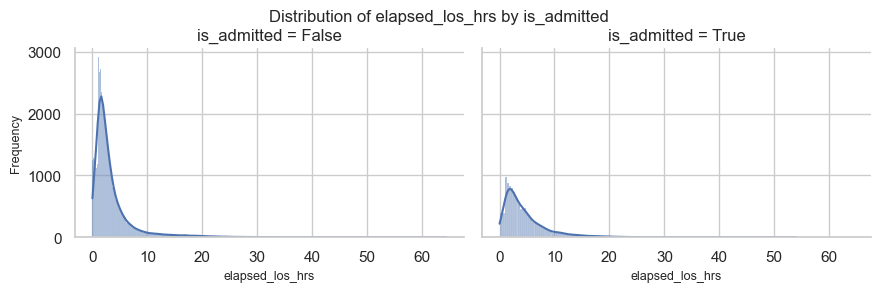

In [12]:
visits['elapsed_los_hrs'] = visits['elapsed_los']/3600
plot_distributions(visits, 'elapsed_los_hrs', 'is_admitted', plot_type='both')

Plotting only the visits of less than 24 hours, we can see a clear picture of activity aimed at getting people discharged within four hours

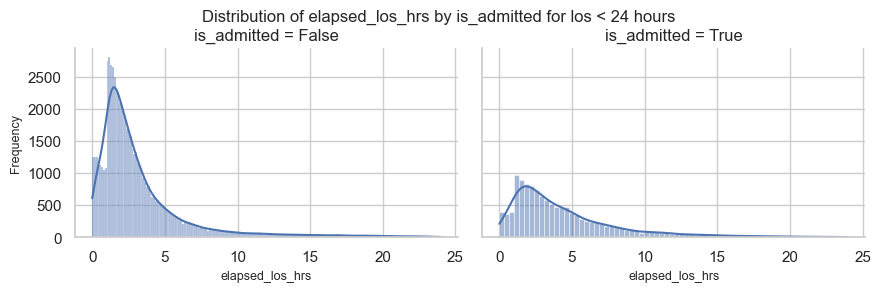

In [13]:
plot_distributions(visits[visits.elapsed_los_hrs < 24], 'elapsed_los_hrs', 'is_admitted', plot_type='both', title = 'Distribution of elapsed_los_hrs by is_admitted for los < 24 hours')

From below, we can see that the long tail of longer visits is more numerous for discharged than for admitted patients 

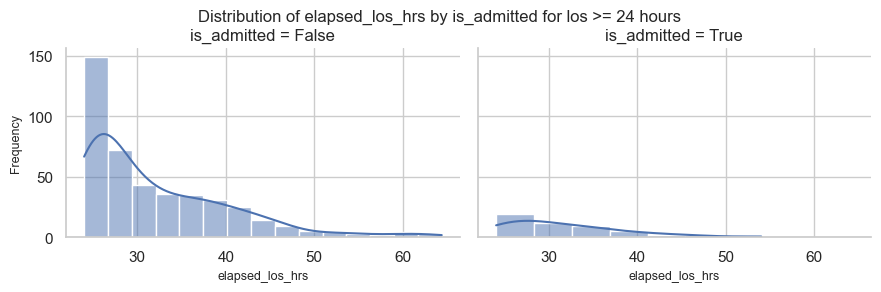

In [82]:
plot_distributions(visits[visits.elapsed_los_hrs >= 24], 'elapsed_los_hrs', 'is_admitted', plot_type='both', title = 'Distribution of elapsed_los_hrs by is_admitted for los >= 24 hours')

#### Sex, age group and arrival method

The charts below show a different distribution between admitted and not admitted patients for both age group (more older people are admitted) and arrival method (most walk-ins are discharged).

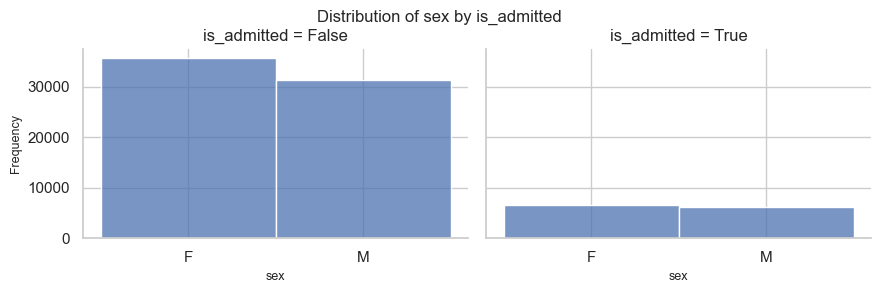

In [83]:
plot_distributions(visits, 'sex', 'is_admitted', plot_type='hist')

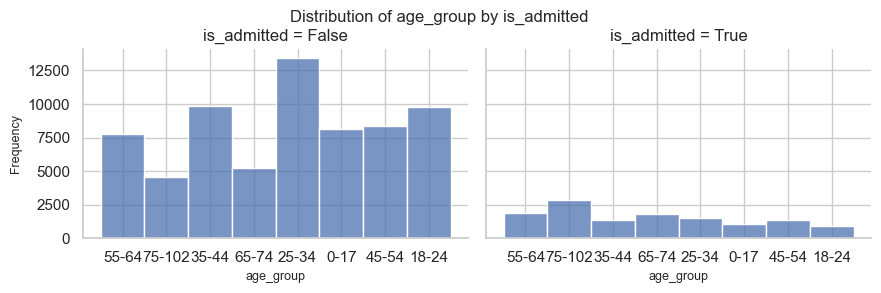

In [84]:
if 'age_group' in visits.columns:
    plot_distributions(visits, 'age_group', 'is_admitted', plot_type='hist')
else:
    plot_distributions(visits, 'age_on_arrival', 'is_admitted', plot_type='hist')


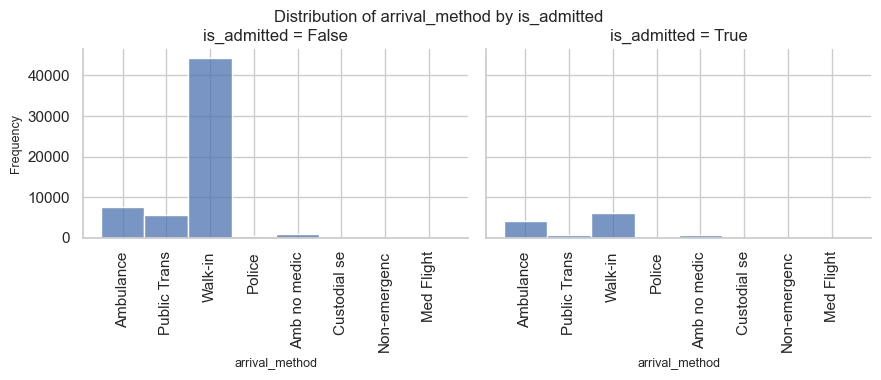

In [85]:
plot_distributions(visits, 'arrival_method', 'is_admitted', plot_type='hist', rotate_x_labels = True)

### Summary variables

The summary variables have counts of the following, up to the moment of the snapshot
* the number of observations recorded
* the number of events at which observations were recorded (if heart rate and respiratory rate have the same timestamp in the original data, this is one event)
* the number of different types of observations (heart rate and respiratory would be two types)
* the number of lab test batteries ordered

In [86]:
dict_cols['summary']

['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

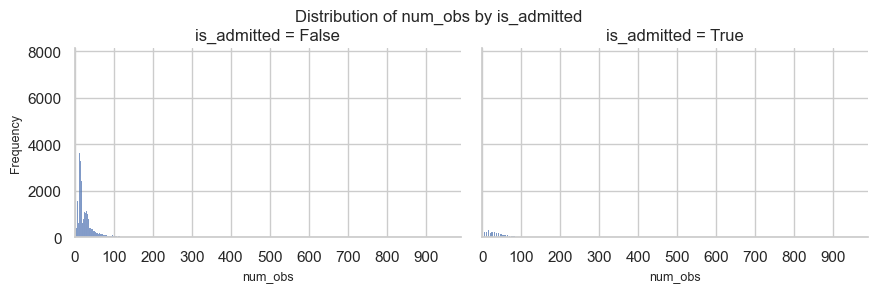

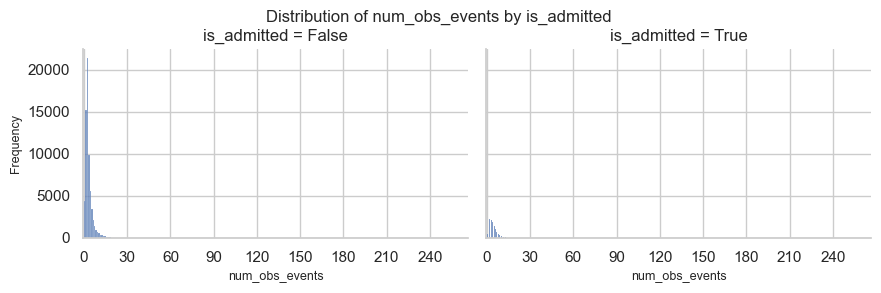

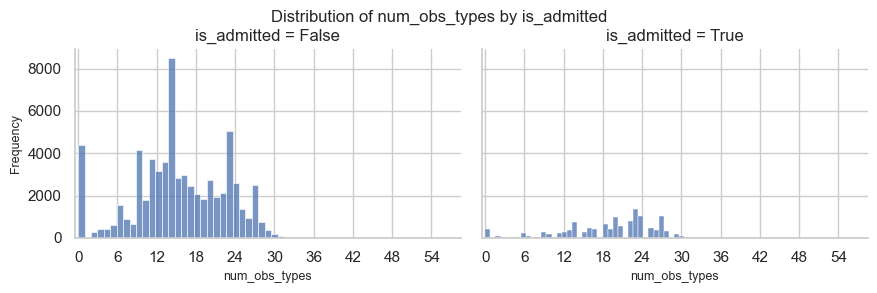

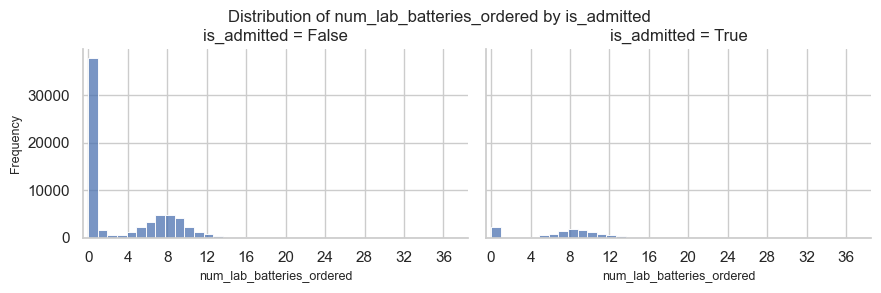

In [87]:
for col_name in dict_cols['summary']:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

In [88]:
print(visits.num_obs.max())
print(visits.num_obs_events.max())

989
266


### Location variables

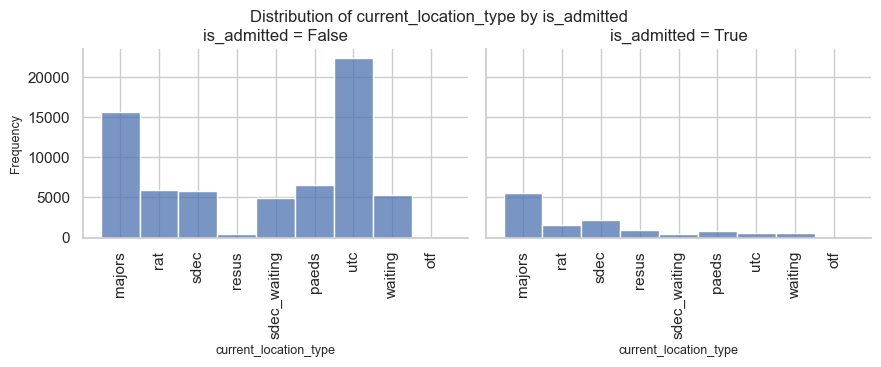

In [89]:
plot_distributions(visits, 'current_location_type', 'is_admitted', plot_type='hist', rotate_x_labels = True)

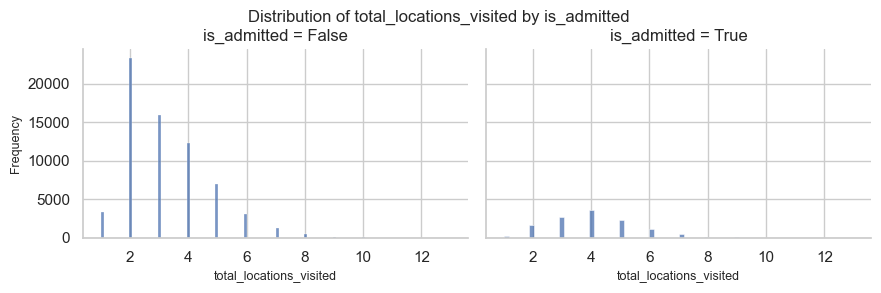

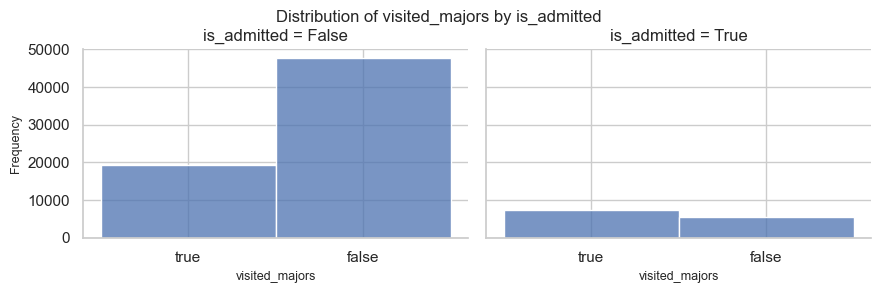

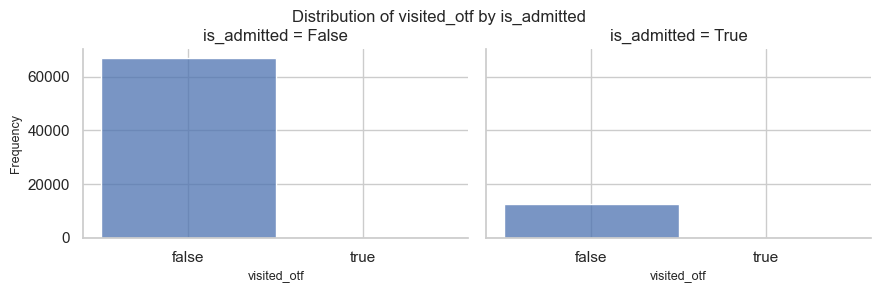

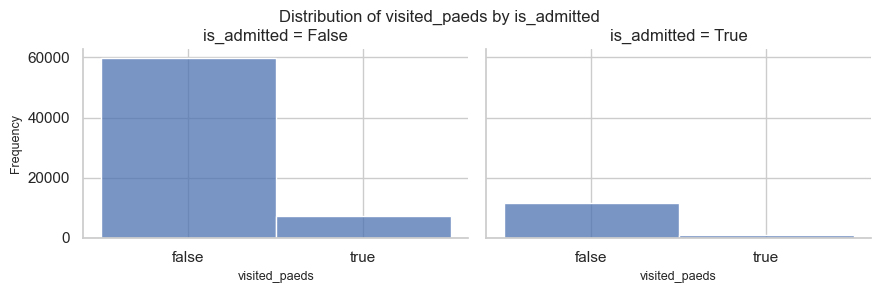

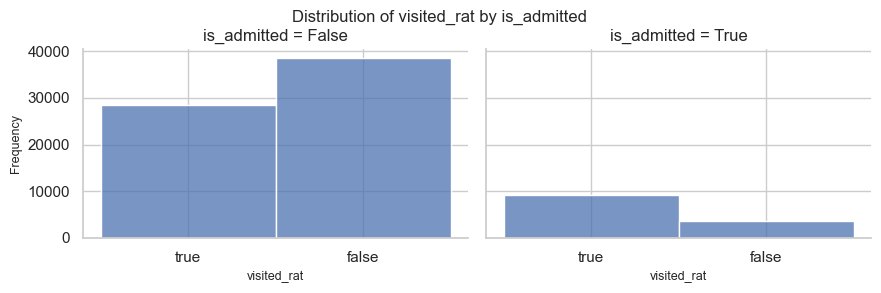

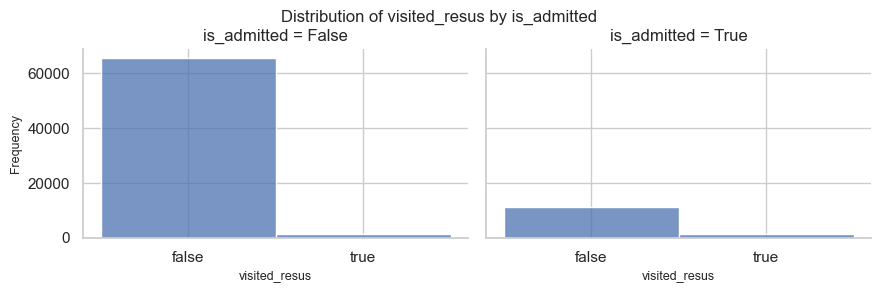

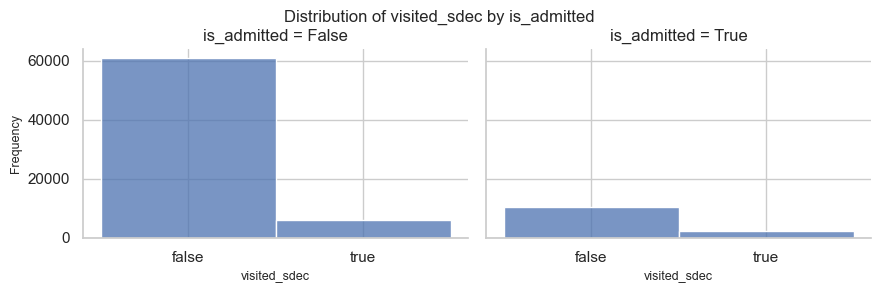

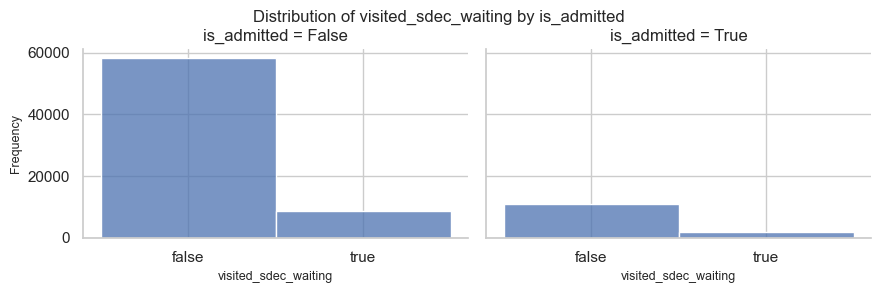

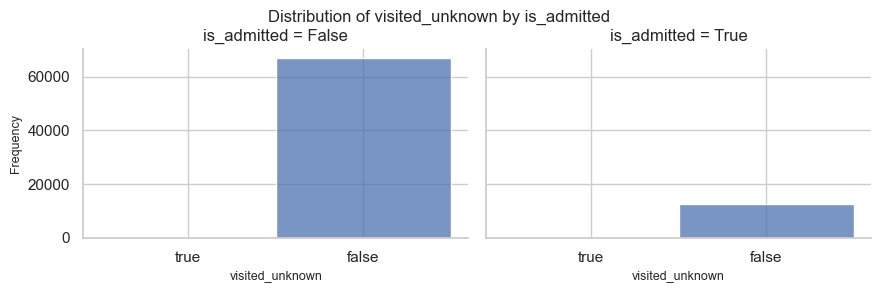

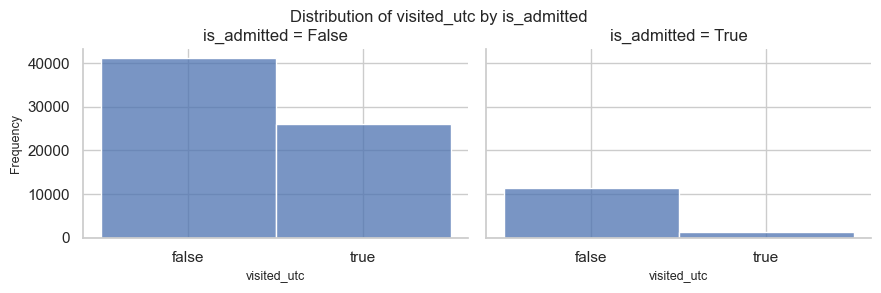

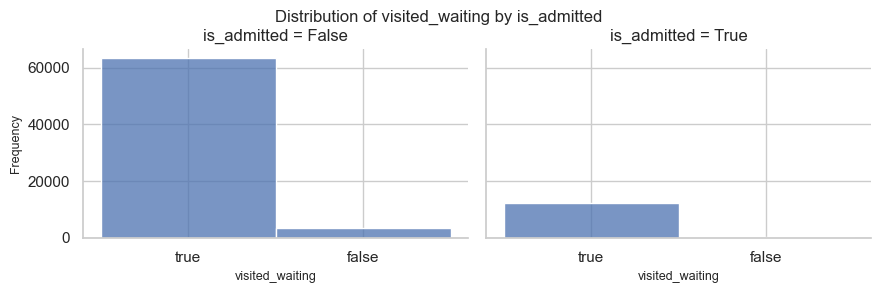

In [90]:
for col_name in dict_cols['location'][1:]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

### Observations variables

In [91]:
dict_cols['observations']

['num_obs_blood_pressure',
 'num_obs_pulse',
 'num_obs_air_or_oxygen',
 'num_obs_glasgow_coma_scale_best_motor_response',
 'num_obs_level_of_consciousness',
 'num_obs_news_score_result',
 'num_obs_manchester_triage_acuity',
 'num_obs_objective_pain_score',
 'num_obs_subjective_pain_score',
 'num_obs_temperature',
 'num_obs_oxygen_delivery_method',
 'num_obs_pupil_reaction_right',
 'num_obs_oxygen_flow_rate',
 'num_obs_uclh_sskin_areas_observed',
 'latest_obs_pulse',
 'latest_obs_respirations',
 'latest_obs_level_of_consciousness',
 'latest_obs_news_score_result',
 'latest_obs_manchester_triage_acuity',
 'latest_obs_objective_pain_score',
 'latest_obs_temperature']

First plotting the variables that count the number of times something was recorded. 

#### Count variables

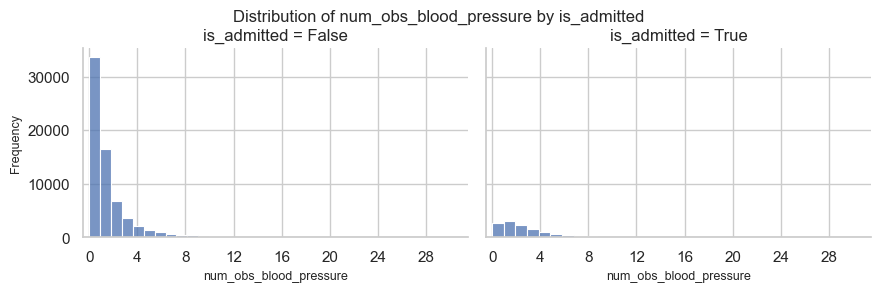

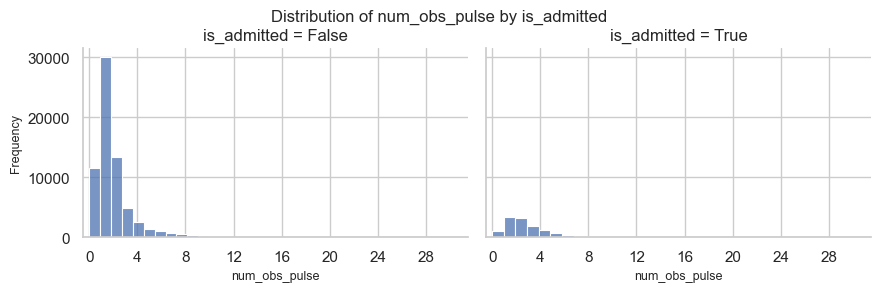

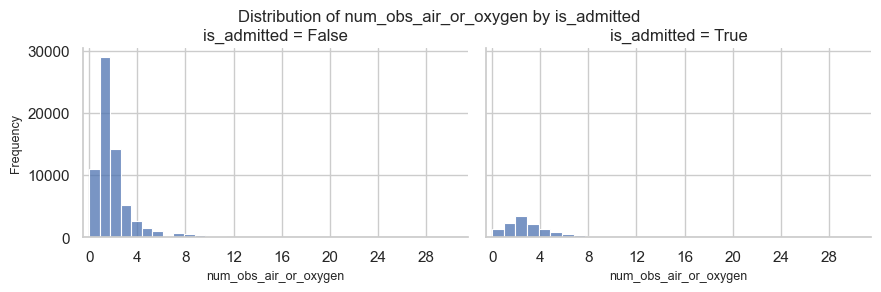

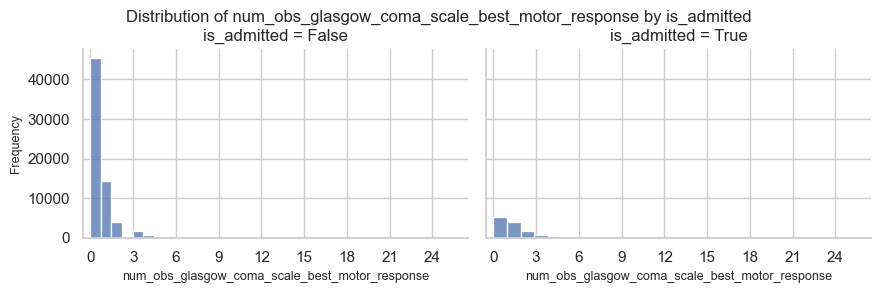

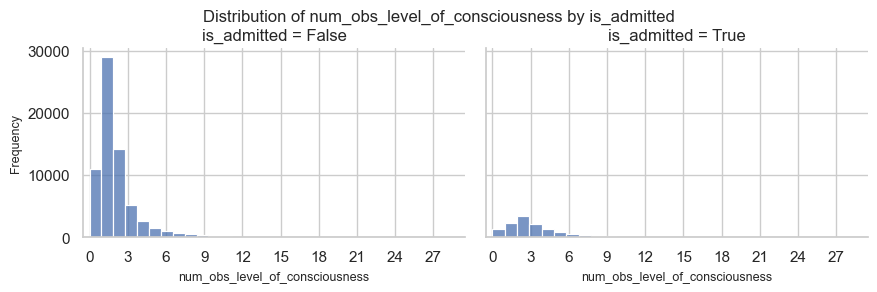

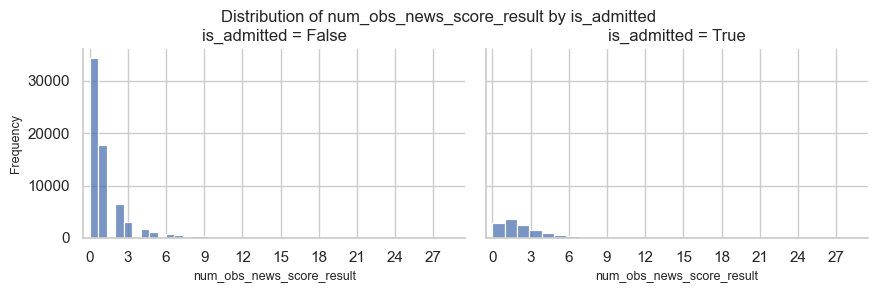

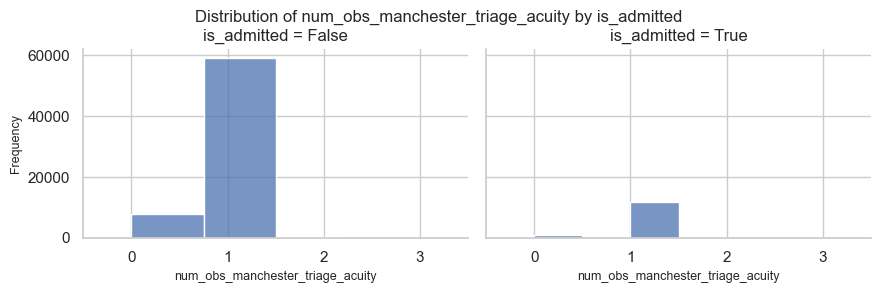

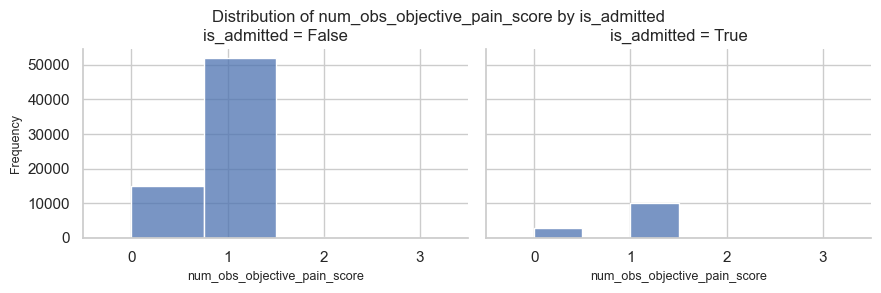

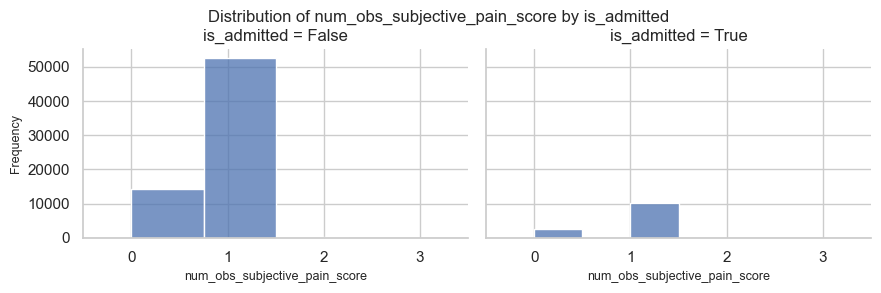

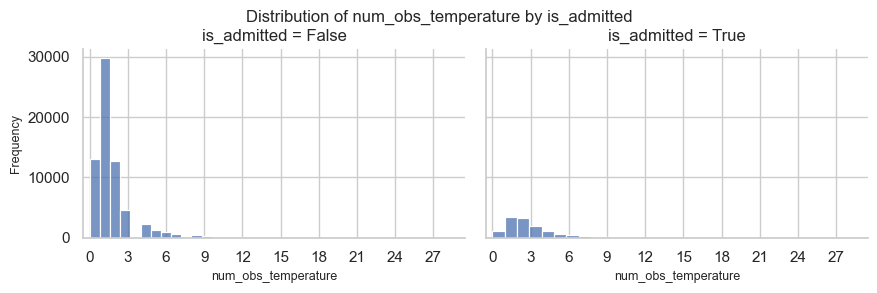

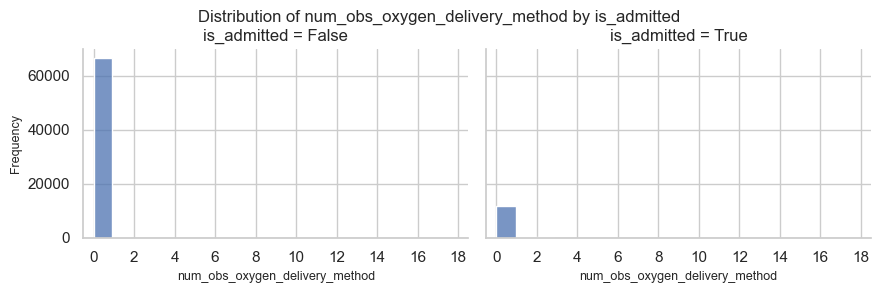

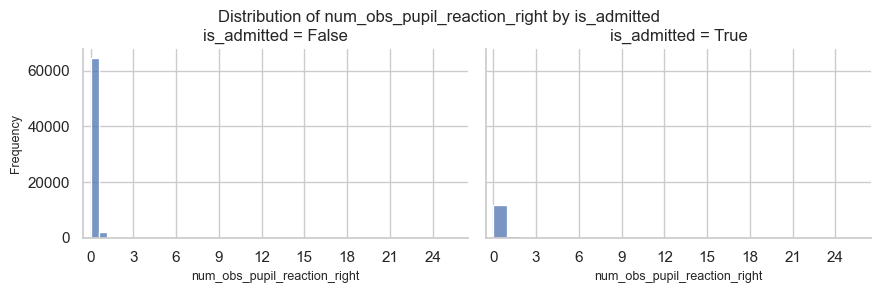

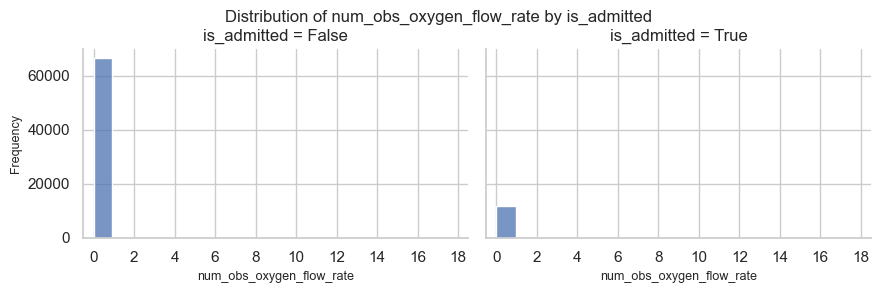

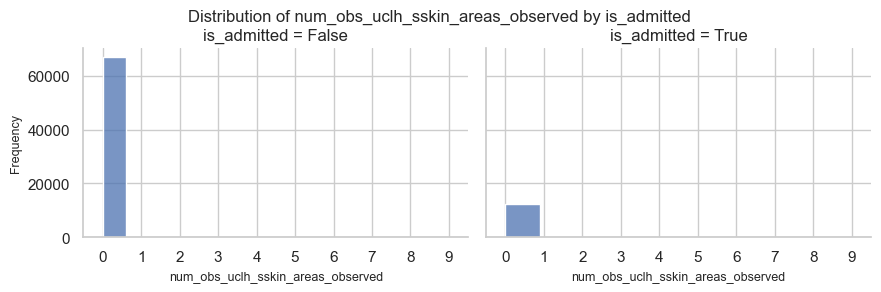

In [92]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('num')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)



Although the charts above are not formatted to show it, there are some higher values on some of these variables, for example:

#### News Scores and Manchester Triage score values

News Scores are commonly used to track the acuity of a patient, and Manchester Triage scores are used at the door of the ED to prioritise patients

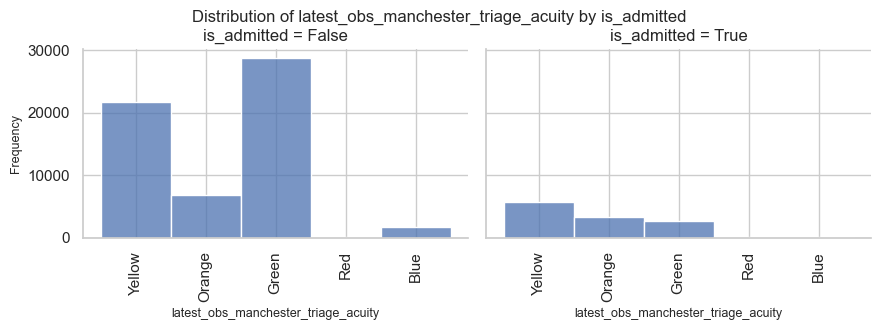

In [93]:
for col_name in [item for item in dict_cols['observations'] if ('manchester' in str(item) ) and str(item).startswith('latest')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', rotate_x_labels = True)

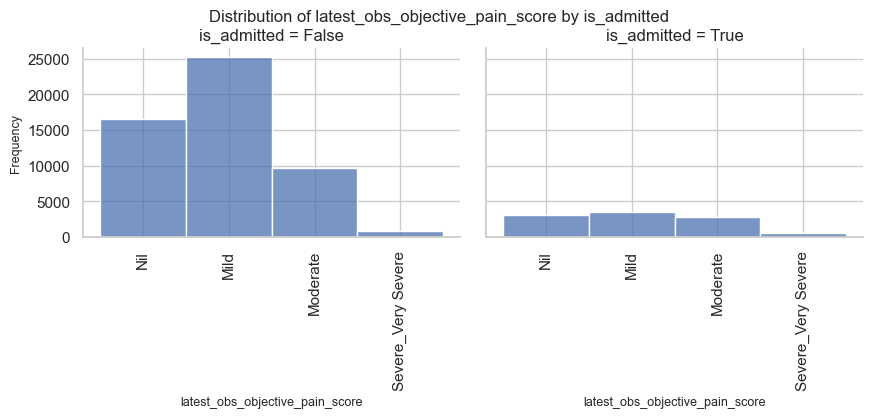

In [94]:
plot_distributions(visits, 'latest_obs_objective_pain_score', 'is_admitted', plot_type='hist', rotate_x_labels = True)


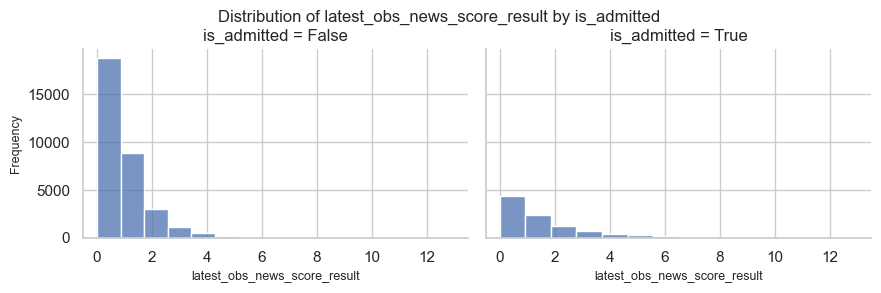

In [95]:
# visits['latest_obs_news_score_result'] = visits.latest_obs_news_score_result.astype("float")

for col_name in [item for item in dict_cols['observations'] if 'news' in str(item) and str(item).startswith('latest')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

The ACVPU score is commonly used to track states of consciousness

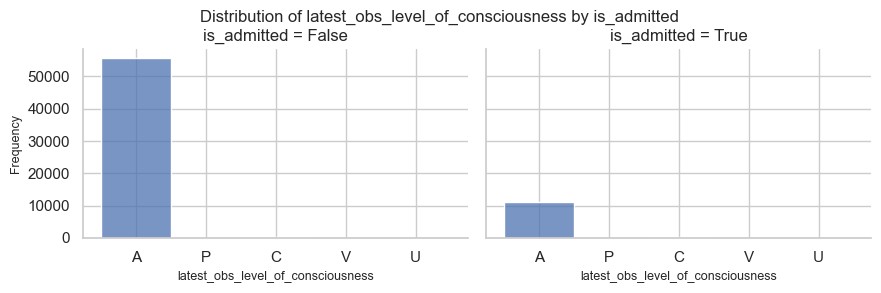

In [96]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

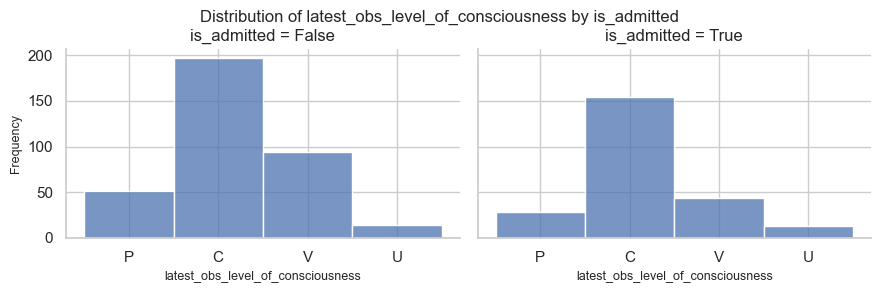

In [97]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_distributions(visits[~(visits.latest_obs_level_of_consciousness == 'A')], col_name, 'is_admitted', plot_type='hist')

#### Vital signs values

There are some outliers here that we may choose to omit

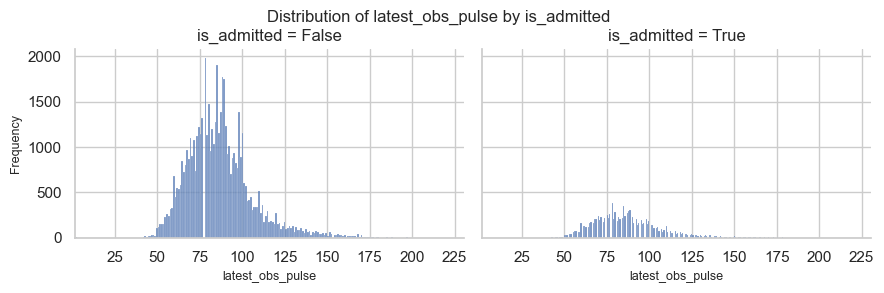

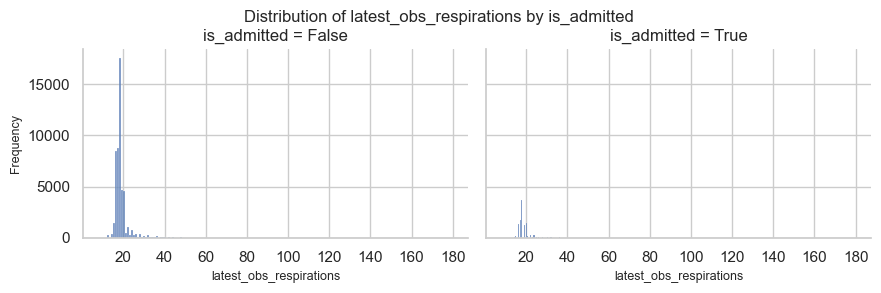

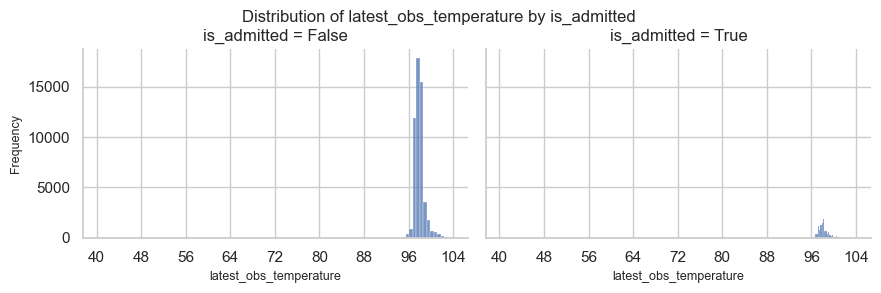

In [98]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('latest') and ('pulse' in str(item) or 'resp' in str(item) or 'temp' in str(item))]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

### Lab variables

In [99]:
dict_cols['lab orders and results']

['lab_orders_bc',
 'lab_orders_bon',
 'lab_orders_crp',
 'lab_orders_csnf',
 'lab_orders_ddit',
 'lab_orders_ncov',
 'lab_orders_rflu',
 'lab_orders_xcov',
 'latest_lab_results_crea',
 'latest_lab_results_hctu',
 'latest_lab_results_k',
 'latest_lab_results_lac',
 'latest_lab_results_na',
 'latest_lab_results_pco2',
 'latest_lab_results_ph',
 'latest_lab_results_wcc',
 'latest_lab_results_alb',
 'latest_lab_results_htrt']

#### Lab orders

It is notable in the charts below, which show whether a lab battery was ordered, that battery CRP (for markers of inflammation) is very commonly ordered for admitted patients; in fact the majority of admitted patients have this lab battery order, whereas a minority of non-admitted patients do not. This difference between admitted and non-admitted (where the majority of admitted have something while the majority of discharged patients do not) only applies to this lab battery order. 

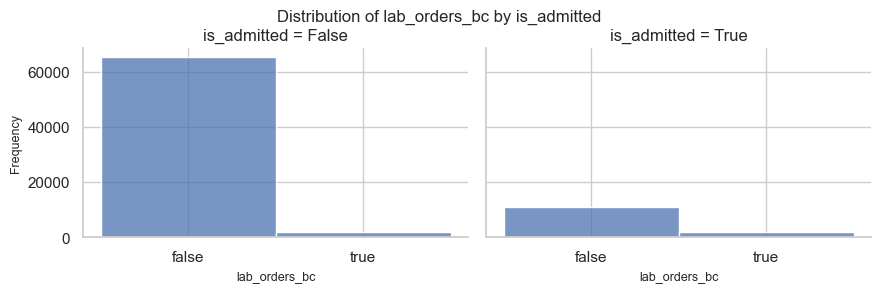

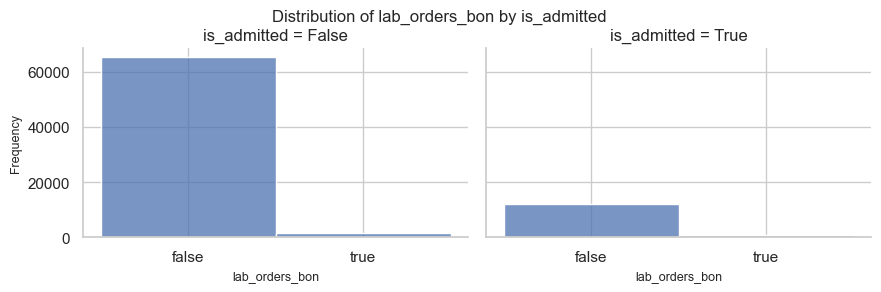

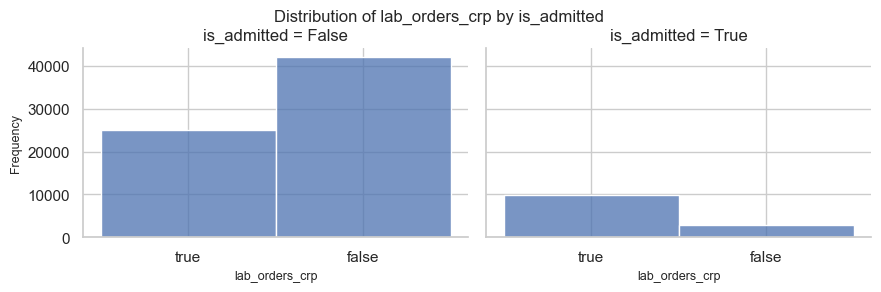

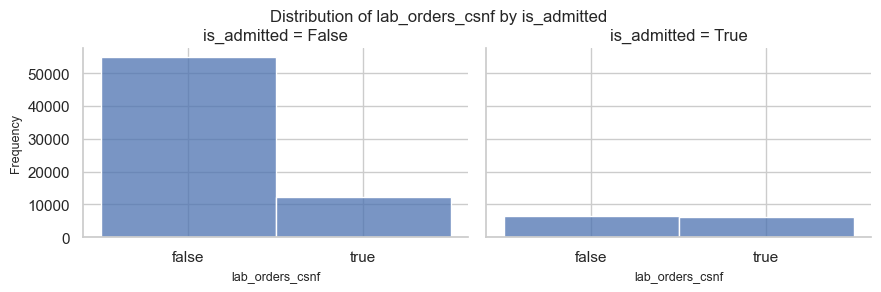

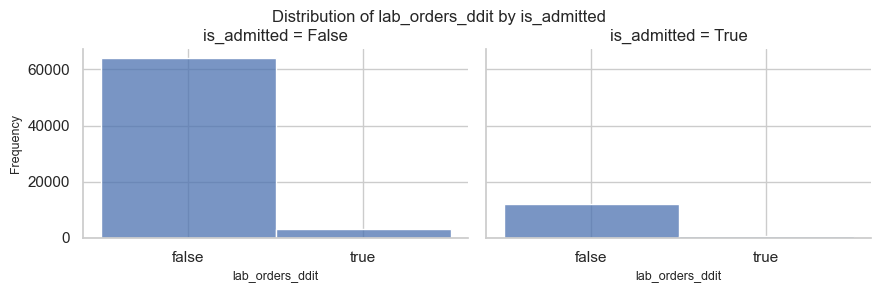

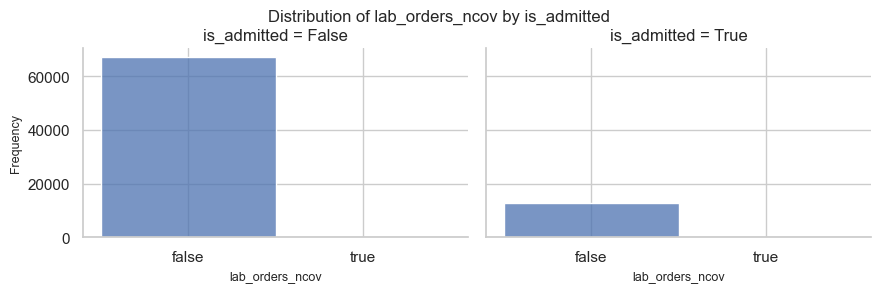

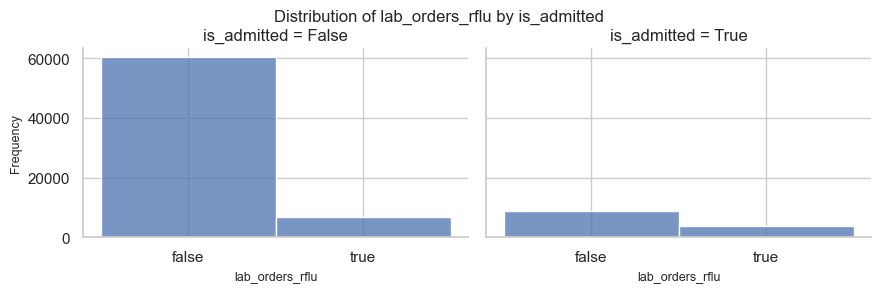

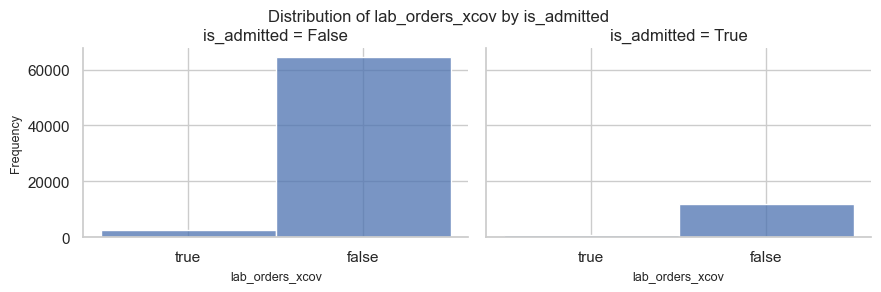

In [100]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('lab') ]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

#### Lab results

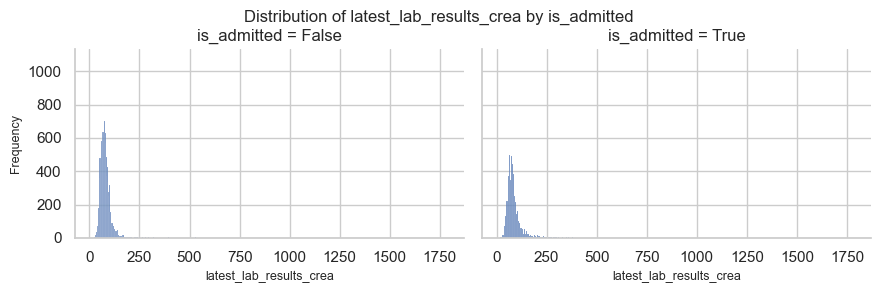

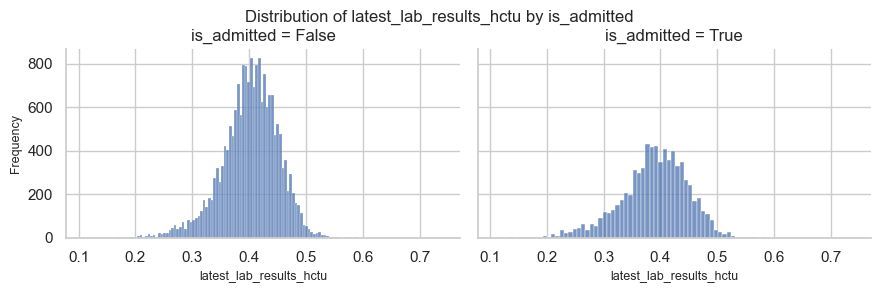

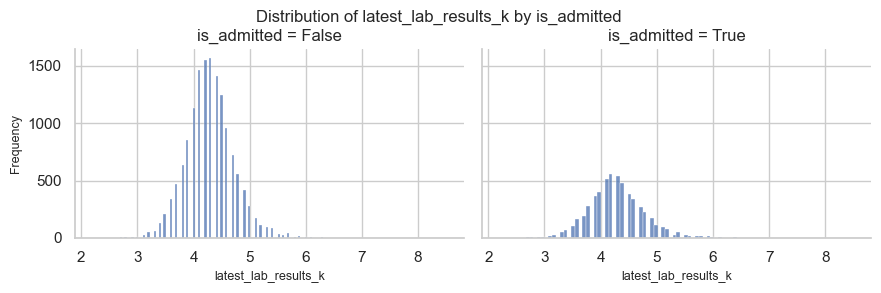

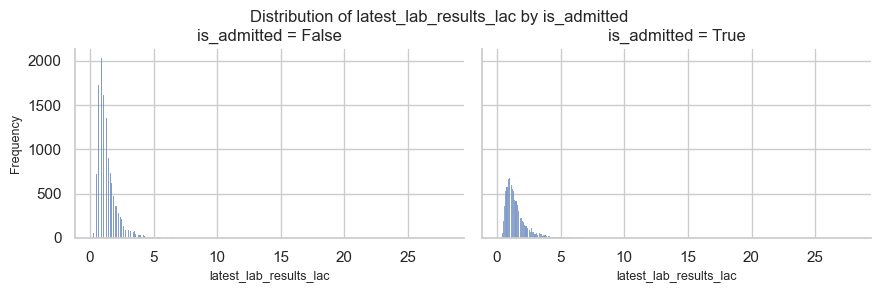

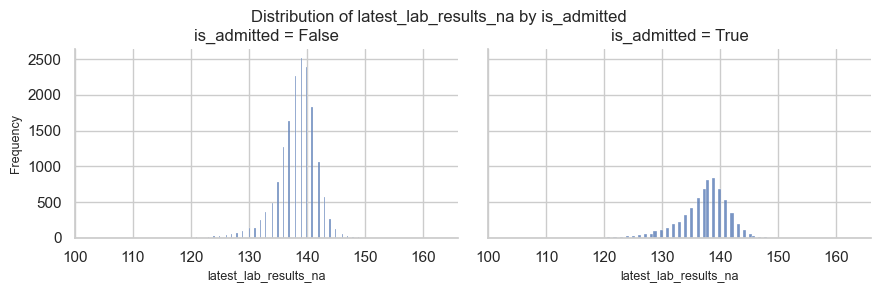

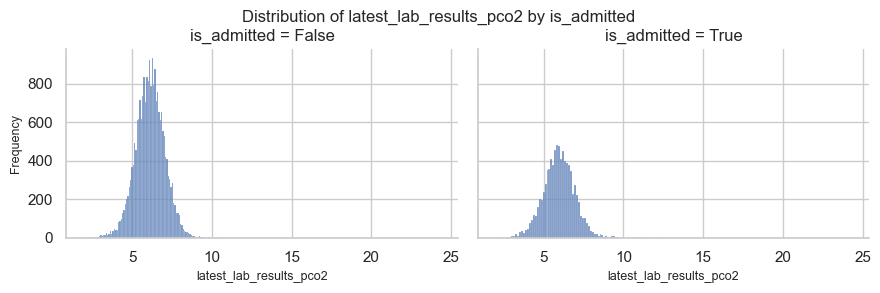

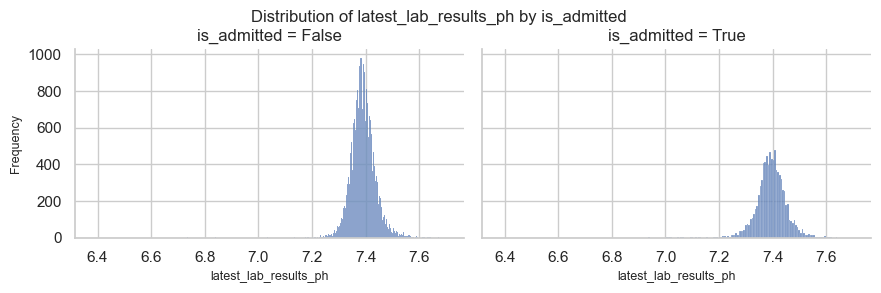

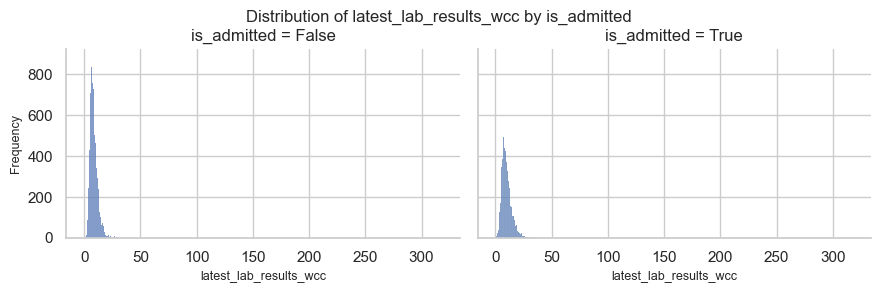

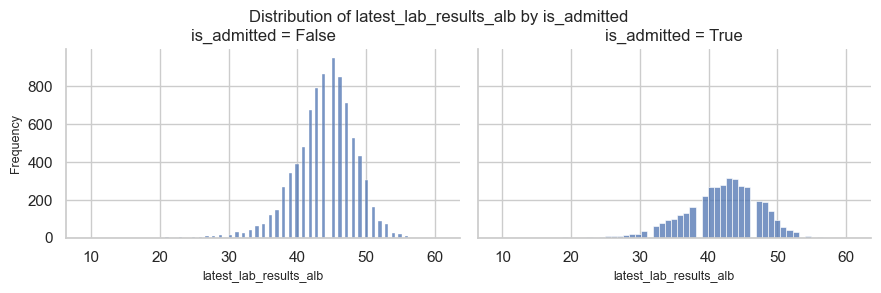

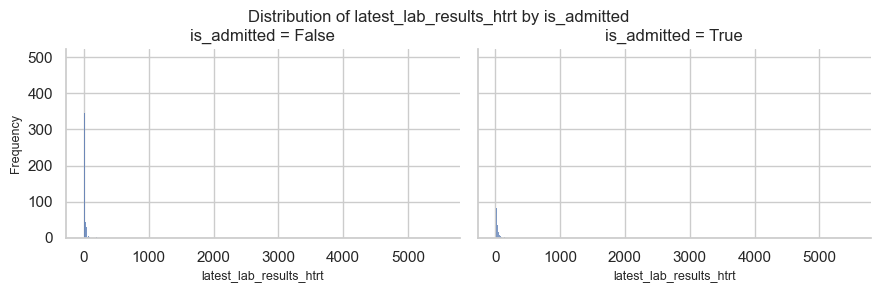

In [101]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('latest') ]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

### Consults variables

In [72]:
dict_cols['consults']


['has_consultation', 'consultation_sequence', 'final_sequence', 'specialty']

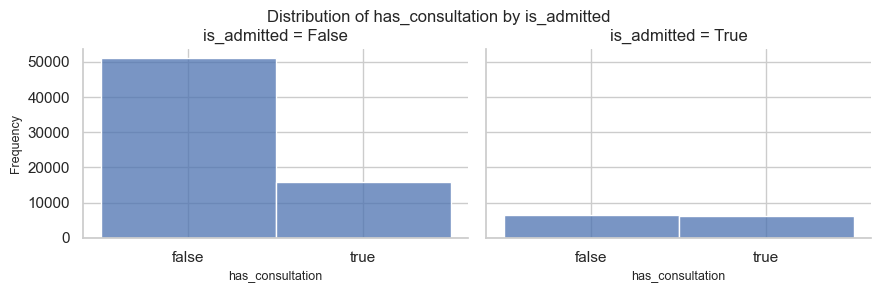

In [73]:
plot_distributions(visits, 'has_consultation', 'is_admitted', plot_type='hist')

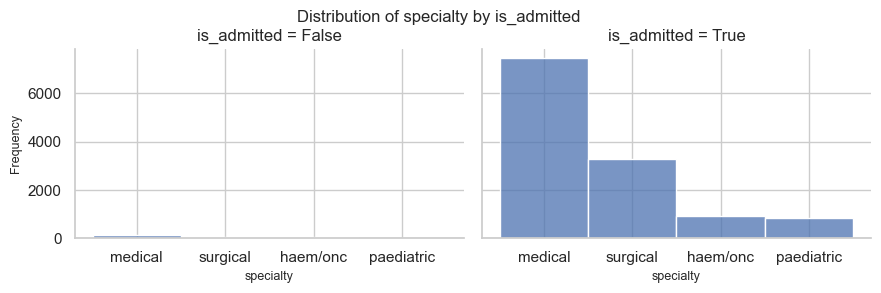

In [74]:
plot_distributions(visits, 'specialty', 'is_admitted', plot_type='hist')

In [76]:
# # Plot code if needed for more detail specialty data

# model_input_path = Path(USER_ROOT / 'ed-predictor' / 'model-input')
# name_mapping = pd.read_csv(str(model_input_path) + '/consults-mapping.csv')

# from matplotlib import pyplot as plt
# spec_summ = visits[visits['consultation_sequence'].map(len) > 0][['consultation_sequence', 'specialty']].explode('consultation_sequence').rename(columns = {'consultation_sequence': 'code'})

# #.reset_index()
# spec_summ = pd.merge(spec_summ, name_mapping, on='code', how='left')
# spec_summ['code_name'] = spec_summ['code'] + ' ' +  spec_summ['name'].str.replace('^Inpatient consult to', '',case=False, regex=True)

# # Group by both 'code_name' and 'specialty' and count occurrences
# frequency = spec_summ.groupby(['code_name', 'specialty']).size().unstack(fill_value=0)

# # Sort the DataFrame by the sum of each row (frequency) in descending order
# frequency_sorted = frequency.sum(axis=1).sort_values(ascending=True)
# frequency = frequency.loc[frequency_sorted.index]

# # Create a figure object with desired size
# fig, ax = plt.subplots(figsize=(20, 20))
# frequency.plot(kind='barh', stacked=True, ax=ax)
# plt.xlabel('Frequency', fontsize=14)
# plt.ylabel('')
# plt.title('Frequency of consultations in ED, mapped to reporting unit on admission', fontsize=18)
# ax.legend(title='Reporting unit', fontsize=14, title_fontsize=16)  # Adjust font sizes here

# # Adjust the spacing between bars on the y-axis
# ax.set_yticks(range(len(frequency.index)))
# ax.set_yticklabels(frequency.index, fontsize=14)
# plt.tight_layout()  # Ensure tight layout to prevent overlapping
# plt.gca().set_aspect('auto')  # Auto-adjust aspect ratio

# plt.show()

## Explore arrivals dataset

In [77]:
arrivals.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child,is_admitted
0,train,2031-04-24 19:21:00+00:00,M,haem/onc,false,True
1,train,2031-04-25 12:42:00+00:00,F,medical,false,True
2,train,2031-03-20 19:54:00+00:00,F,haem/onc,false,True
3,train,2031-03-04 22:03:00+00:00,F,haem/onc,false,True
4,train,2031-03-01 11:10:44+00:00,M,surgical,false,True


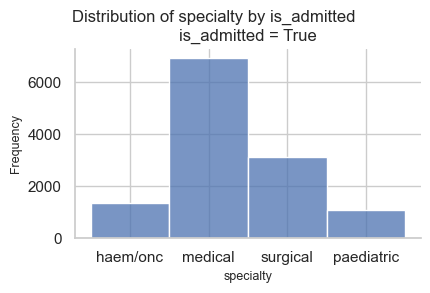

In [78]:
arrivals['is_admitted'] = True
plot_distributions(arrivals, 'specialty', 'is_admitted', plot_type='hist')

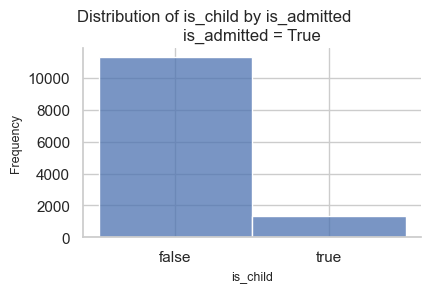

In [79]:
plot_distributions(arrivals, 'is_child', 'is_admitted', plot_type='hist')